# Comparative analysis description

The purpose of the analysis is to verify which of the graph embedding methods implemented in the ReLeGy package are applicable to the graph visualization task. We compare whether the clusters of vertices are properly separated and whether the visual graph structure is preserved. The higher dimensional embeddings are visualized with PCA algorithm to ensure minimal changes in dimensionality reduction.

# Input data description

## Graphs 

* Barbell graph having two cliques of 20 vertices connected with a path of 5 vertices
* A cycle of 40 vertices
* A graph consisting of 5 cliques connected by random edges with density equal to 0.002 with 100 vertices in total
* A graph consisting of 7 cliques connected by random edges with density equal to 0.03 with 100 vertices in total
* A graph consisting of 7 clusters with inner density 0.8 connected by random edges with outer density equal to 0.03 with 100 vertices in total

## Embedding methods

* LaplacianEigenmaps
* GraphFactorization
* GraRep
* HOPE
* DeepWalk
* Node2Vec
* LINE
* HARP(DeepWalk)
* HARP(Node2Vec)
* Struc2Vec
* GraphWave

The GNN and GCN embedding methods are left out in this comparison, as they require the vertices to be labeled.

## Embedding dimensions

Each graph is embedded with each method three times, so that the resulting matrices have 2, 6, and 20 columns.

# Setup

In [3]:
import os
os.chdir("..")
import relegy.embeddings as rle
import relegy.graphs as rlr
os.chdir("Analysis")

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import inspect
from IPython.display import clear_output
from matplotlib.pylab import rcParams
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
import pickle
import re

In [18]:
def get_embedding_methods_iterable():
    """
    Iterates over embedding methods.
    """
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

def plot_graph(graph):
    rcParams["figure.figsize"] = 5,5
    nx.draw(graph[0], node_color=graph[1])

def plot_embeddings(embeddings):
    rcParams["figure.figsize"] = 16, 16
    fig, axs = plt.subplots(4, 4)
    names = list(embeddings[0].keys())
    for i in range(len(names)):
        ix_x = i // 4
        ix_y = i % 4
        cur_Z = embeddings[0][names[i]]
        if cur_Z.shape[1] != 2:
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
        axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
        axs[ix_x, ix_y].set_title(names[i])
        axs[ix_x, ix_y].set_xticks([])
        axs[ix_x, ix_y].set_yticks([])
    while(i < 15):
        i += 1
        ix_x = i // 4
        ix_y = i % 4
        axs[ix_x, ix_y].axis('off')
    plt.show()
    
def plot_embeddings_all_d(embeddings_d2, embeddings_d6, embeddings_d20, labels):
    names = list(embeddings_d2.keys())
    rcParams["figure.figsize"] = 16, 4*len(names)
    fig, axs = plt.subplots(len(names), 3)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    for i, name in enumerate(names):
        ix_x = i
        ix_y = 0
        
        if len(names) > 1:
            # d2
            cur_Z = embeddings_d2[name]
            axs[ix_x, 0].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
            axs[ix_x, 0].set_title(f"{name}, d=2", size=24)
            axs[ix_x, 0].set_xticks([])
            axs[ix_x, 0].set_yticks([])
            # d6
            cur_Z = embeddings_d6[name]
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
            axs[ix_x, 1].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
            axs[ix_x, 1].set_title(f"{name}, d=6", size=24)
            axs[ix_x, 1].set_xticks([])
            axs[ix_x, 1].set_yticks([])
            # d20
            cur_Z = embeddings_d20[name]
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
            axs[ix_x, 2].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
            axs[ix_x, 2].set_title(f"{name}, d=20", size=24)
            axs[ix_x, 2].set_xticks([])
            axs[ix_x, 2].set_yticks([])
        else:
            # d2
            cur_Z = embeddings_d2[name]
            axs[0].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
            axs[0].set_title(f"{name}, d=2", size=24)
            axs[0].set_xticks([])
            axs[0].set_yticks([])
            # d6
            cur_Z = embeddings_d6[name]
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
            axs[1].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
            axs[1].set_title(f"{name}, d=6", size=24)
            axs[1].set_xticks([])
            axs[1].set_yticks([])
            # d20
            cur_Z = embeddings_d20[name]
            ss = StandardScaler().fit_transform(cur_Z)
            pca_Z = PCA(n_components=2).fit_transform(cur_Z)
            cur_Z = pca_Z
            axs[2].scatter(cur_Z[:, 0], cur_Z[:, 1], c=labels)
            axs[2].set_title(f"{name}, d=20", size=24)
            axs[2].set_xticks([])
            axs[2].set_yticks([])
    
def get_results_from_all_viable_methods(d, graphs, graph_names=None):
    results = [None] * len(graphs)
    for i, G in enumerate(graphs):
        results_dictionary = {}
        for name, class_handle in get_embedding_methods_iterable():
            info = "Currently processing " + str(name) + ", d: " + str(d)
            if graph_names is not None:
                info += ", graph: " + graph_names[i]
            if not (name == "GCN" or name == "GNN"):
                if name in ["GraphWave", "HOPE", "LINE"]:
                    current_d = d // 2
                else:
                    current_d = d
                print(info)
                if not (name == "HARP"):
                    results_dictionary[name] = class_handle.fast_embed(G, d=current_d)
                    clear_output()
                else:
                    temp_name = "HARP_Deepwalk"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d)
                    temp_name = "HARP_Node2Vec"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d, method = "Node2Vec")
                    clear_output()
        results[i] = results_dictionary
    return results

In [7]:
#Graph generation
np.random.seed(123)
G1, labels1 = rlr.generate_graph("barbell", m1=20, m2=5), np.concatenate((np.repeat(1, 19), np.array([0, 2, 3, 4, 3, 2, 0]), np.repeat(1, 19)))
G2, labels2 = nx.cycle_graph(40), np.repeat(1, 40)
G3, labels3 = rlr.generate_clusters_graph(100, 5, 0.002, 1)
G4, labels4 = rlr.generate_clusters_graph(100, 7, 0.03, 1)
G5, labels5 = rlr.generate_clusters_graph(100, 7, 0.03, 0.8)
labels = [labels1, labels2, labels3, labels4, labels5]

In [67]:
# Code for interactive visualization

# def plot_embeddings(embeddings):
#     rcParams["figure.figsize"] = 16, 16
#     fig, axs = plt.subplots(4, 4)
#     names = list(embeddings[0].keys())
#     for i in range(len(names)):
#         ix_x = i // 4
#         ix_y = i % 4
#         cur_Z = embeddings[0][names[i]]
#         if cur_Z.shape[1] != 2:
#             ss = StandardScaler().fit_transform(cur_Z)
#             pca_Z = PCA(n_components=2).fit_transform(cur_Z)
#             cur_Z = pca_Z
#         axs[ix_x, ix_y].scatter(cur_Z[:, 0], cur_Z[:, 1], c=embeddings[1])
#         axs[ix_x, ix_y].set_title(names[i])
#         axs[ix_x, ix_y].set_xticks([])
#         axs[ix_x, ix_y].set_yticks([])
#     while(i < 15):
#         i += 1
#         ix_x = i // 4
#         ix_y = i % 4
#         axs[ix_x, ix_y].axis('off')
#     plt.show()
        
# dpdown = widgets.Dropdown(options=[('G1', (embeddings_d6[0], labels[0]))],
#                                     value=(embeddings_d6[0], labels[0]),
#                                     description="Graph: ")
# with dpdown.hold_trait_notifications():
#     dpdown.options = [('G1', (embeddings_d6[0], labels[0])), 
#                        ('G2', (embeddings_d6[1], labels[1])), 
#                        ('G4', (embeddings_d6[3], labels[3])), 
#                        ('G3', (embeddings_d6[2], labels[2])), 
#                        ('G5', (embeddings_d6[4], labels[4]))]
# interact(plot_embeddings, embeddings = dpdown)
# plt.show()

# Analysis

## Graphs

### G1 - Barbell

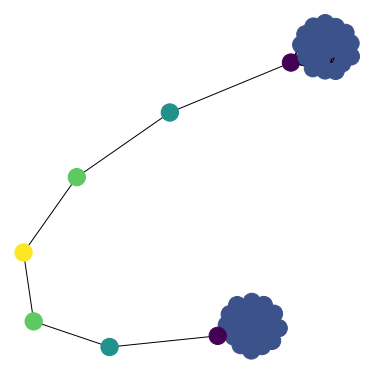

In [71]:
plot_graph((G1, labels1))
plt.savefig("Visualization/Visualization-G1.png", transparent=True)

### G2 - Cycle

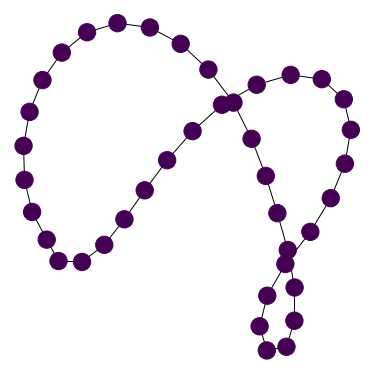

In [72]:
plot_graph((G2, labels2))
plt.savefig("Visualization/Visualization-G2.png", transparent=True)

### G3 - barely connected clusters

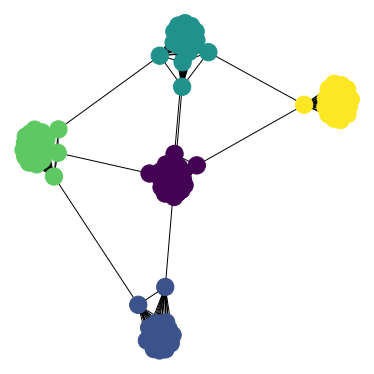

In [73]:
plot_graph((G3, labels3))
plt.savefig("Visualization/Visualization-G3.png", transparent=True)

### G4 - loosely connected clusters

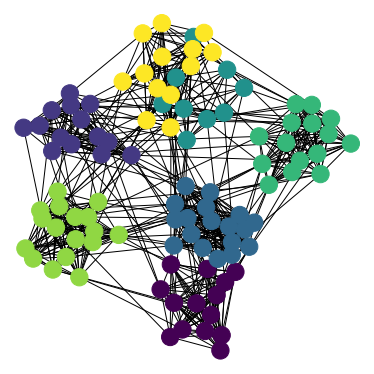

In [74]:
plot_graph((G4, labels4))
plt.savefig("Visualization/Visualization-G4.png", transparent=True)

### G5 - weak connections inside clusters

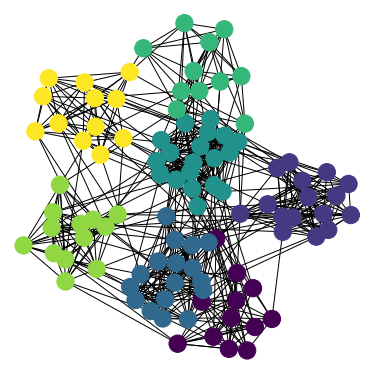

In [75]:
plot_graph((G5, labels5))
plt.savefig("Visualization/Visualization-G5.png", transparent=True)

## Embeddings computation

In [ ]:
#embeddings_d2 = get_results_from_all_viable_methods(d=2, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])
#embeddings_d6 = get_results_from_all_viable_methods(d=6, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])
#embeddings_d20 = get_results_from_all_viable_methods(d=20, graphs=[G1, G2, G3, G4, G5], graph_names=["G"+str(i) for i in range(1, 6)])

In [5]:
embeddings = {}
for i in range(1, 6):
    for j in [2, 6, 20]:
        with open("Visualization/G"+str(i)+"_results_vis_d"+str(j)+".p", mode="rb") as f:
            embeddings["G"+str(i)+"_"+"d"+str(j)] = pickle.load(f)
embeddings_d2 = [None] * 5
embeddings_d6 = [None] * 5
embeddings_d20 = [None] * 5
k = 0
l = 0
m = 0
for i in embeddings.keys():
    if re.search("d2$", i) is not None:
        embeddings_d2[k] = embeddings[i]
        k += 1
    elif "d6" in i:
        embeddings_d6[l] = embeddings[i]
        l += 1
    elif "d20" in i:
        embeddings_d20[m] = embeddings[i]
        m += 1

## Visualization comparison

### G1 - Barbell

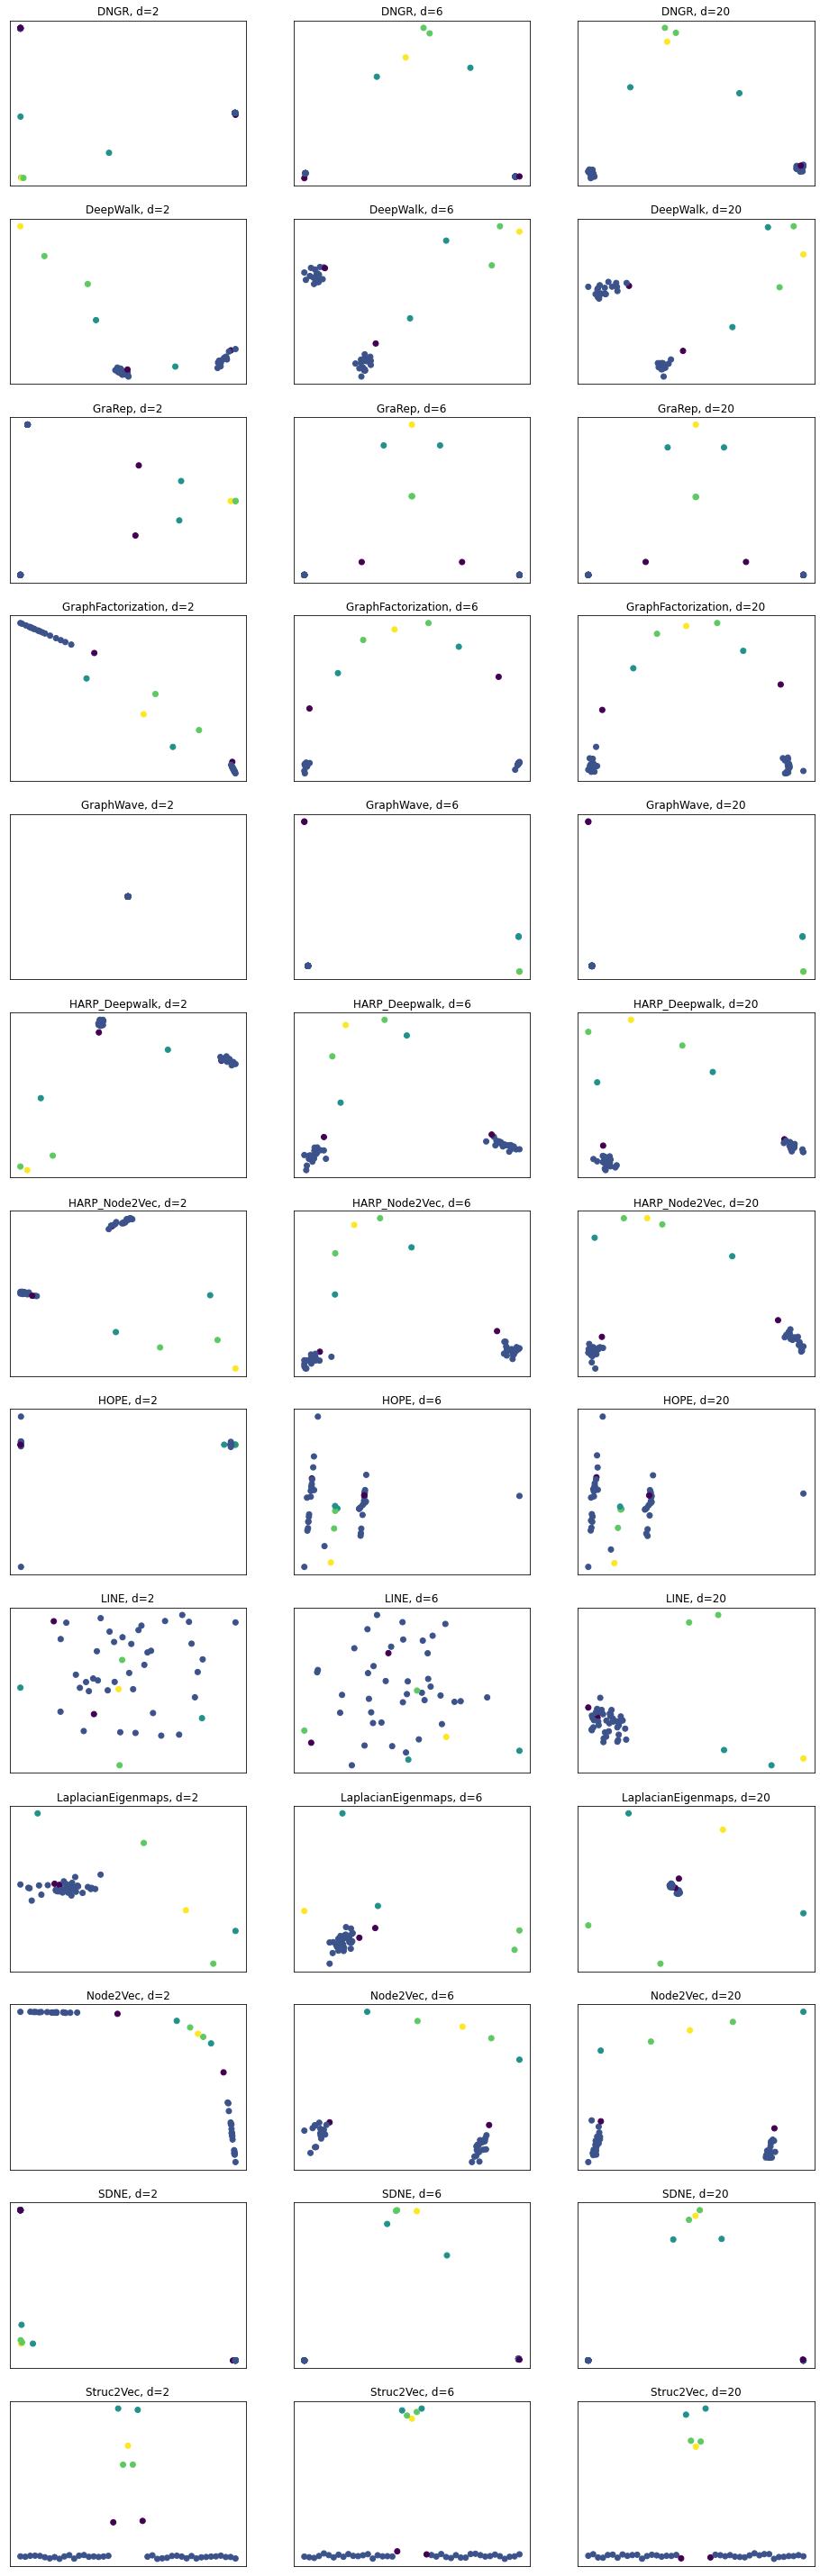

In [100]:
plot_embeddings_all_d(embeddings_d2[0], embeddings_d6[0], embeddings_d20[0], labels[0])
plt.savefig(f"Visualization/Visualization-G1.png", transparent=True)

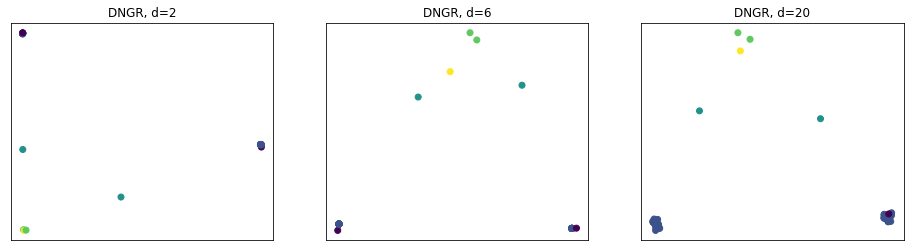

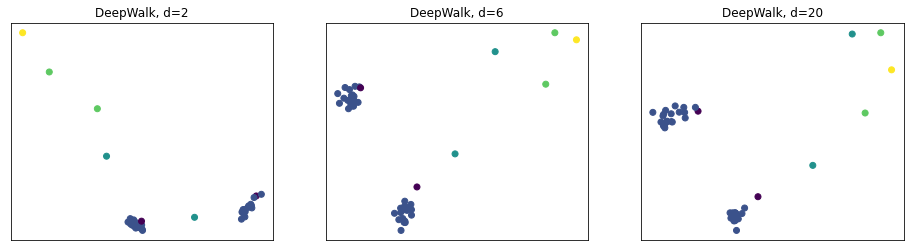

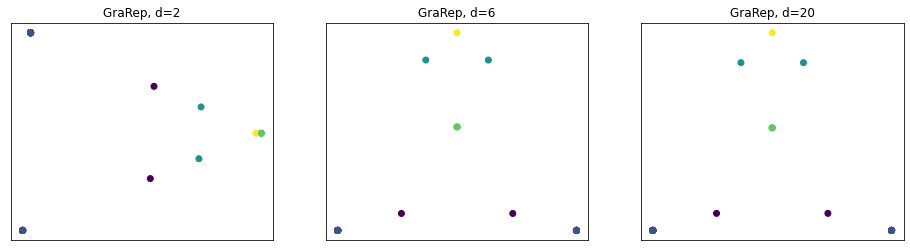

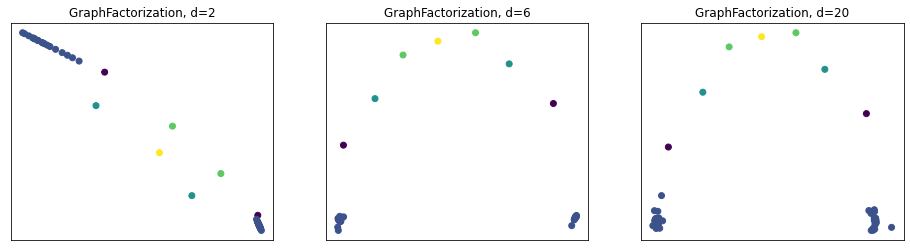

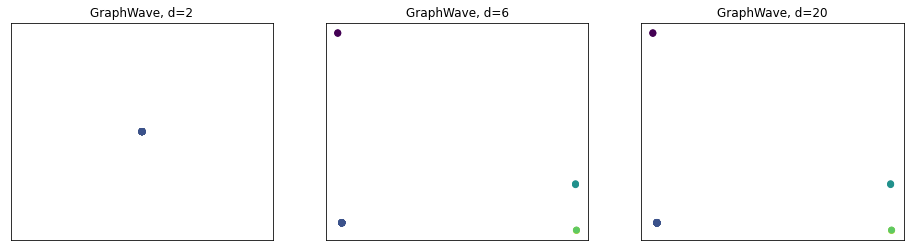

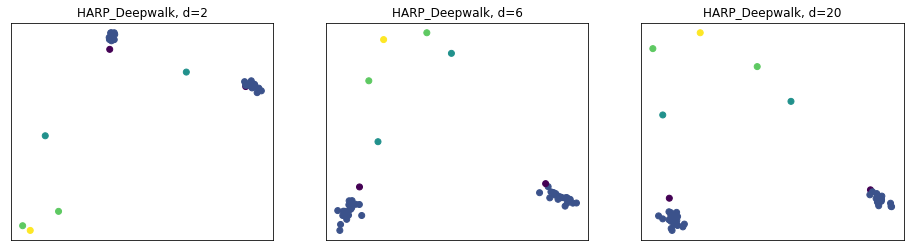

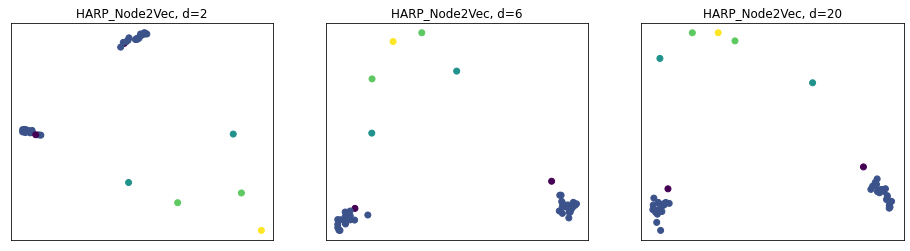

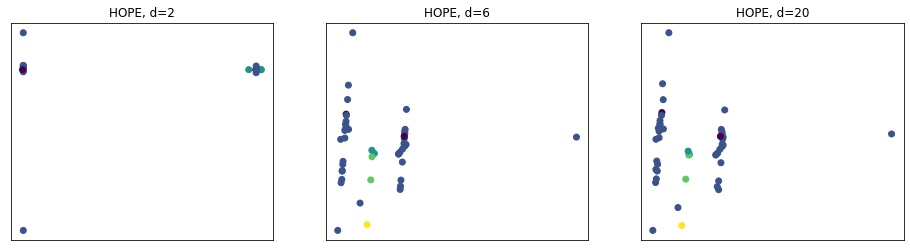

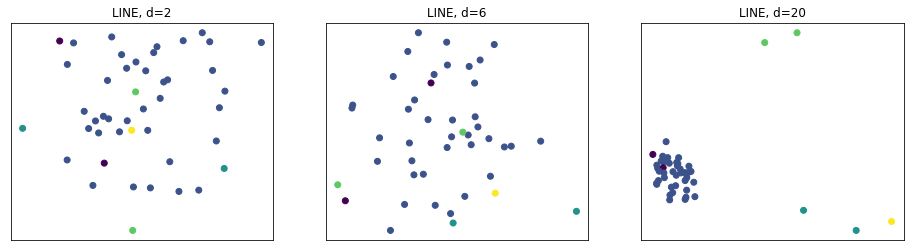

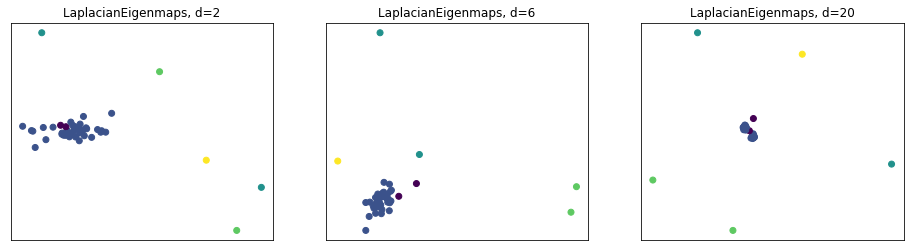

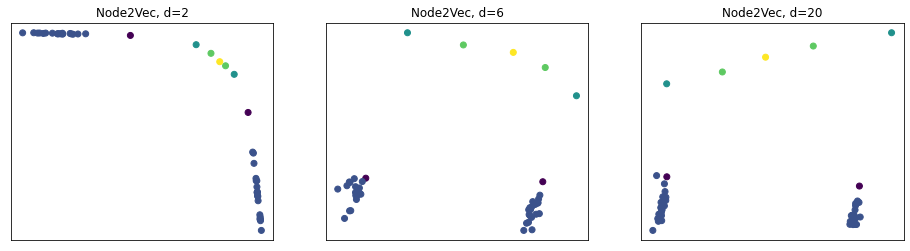

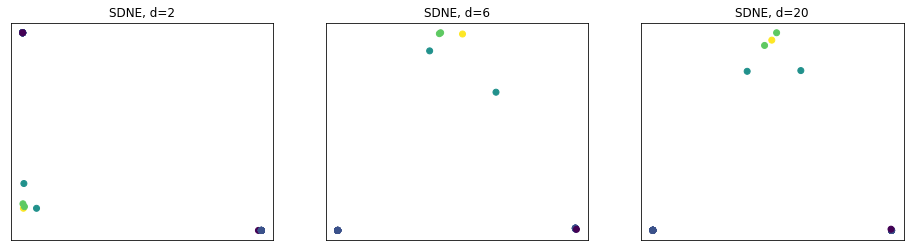

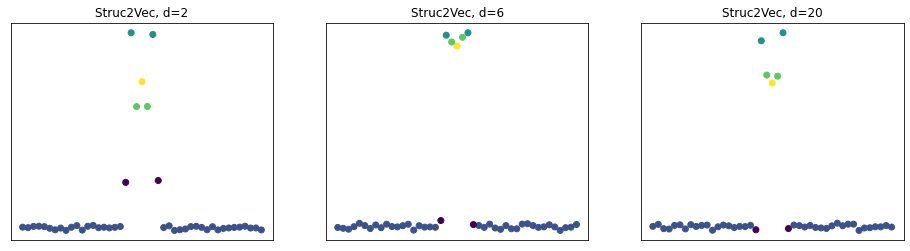

In [88]:
g_num = 0

for key in embeddings_d6[g_num].keys():
    ed2 = {key: embeddings_d2[g_num][key]}
    ed6 = {key: embeddings_d6[g_num][key]}
    ed20 = {key: embeddings_d20[g_num][key]}
    plot_embeddings_all_d(ed2, ed6, ed20, labels[g_num])
    plt.savefig(f"Visualization/Visualization-G1-{key}.png", transparent=True)

### G2 - Cycle

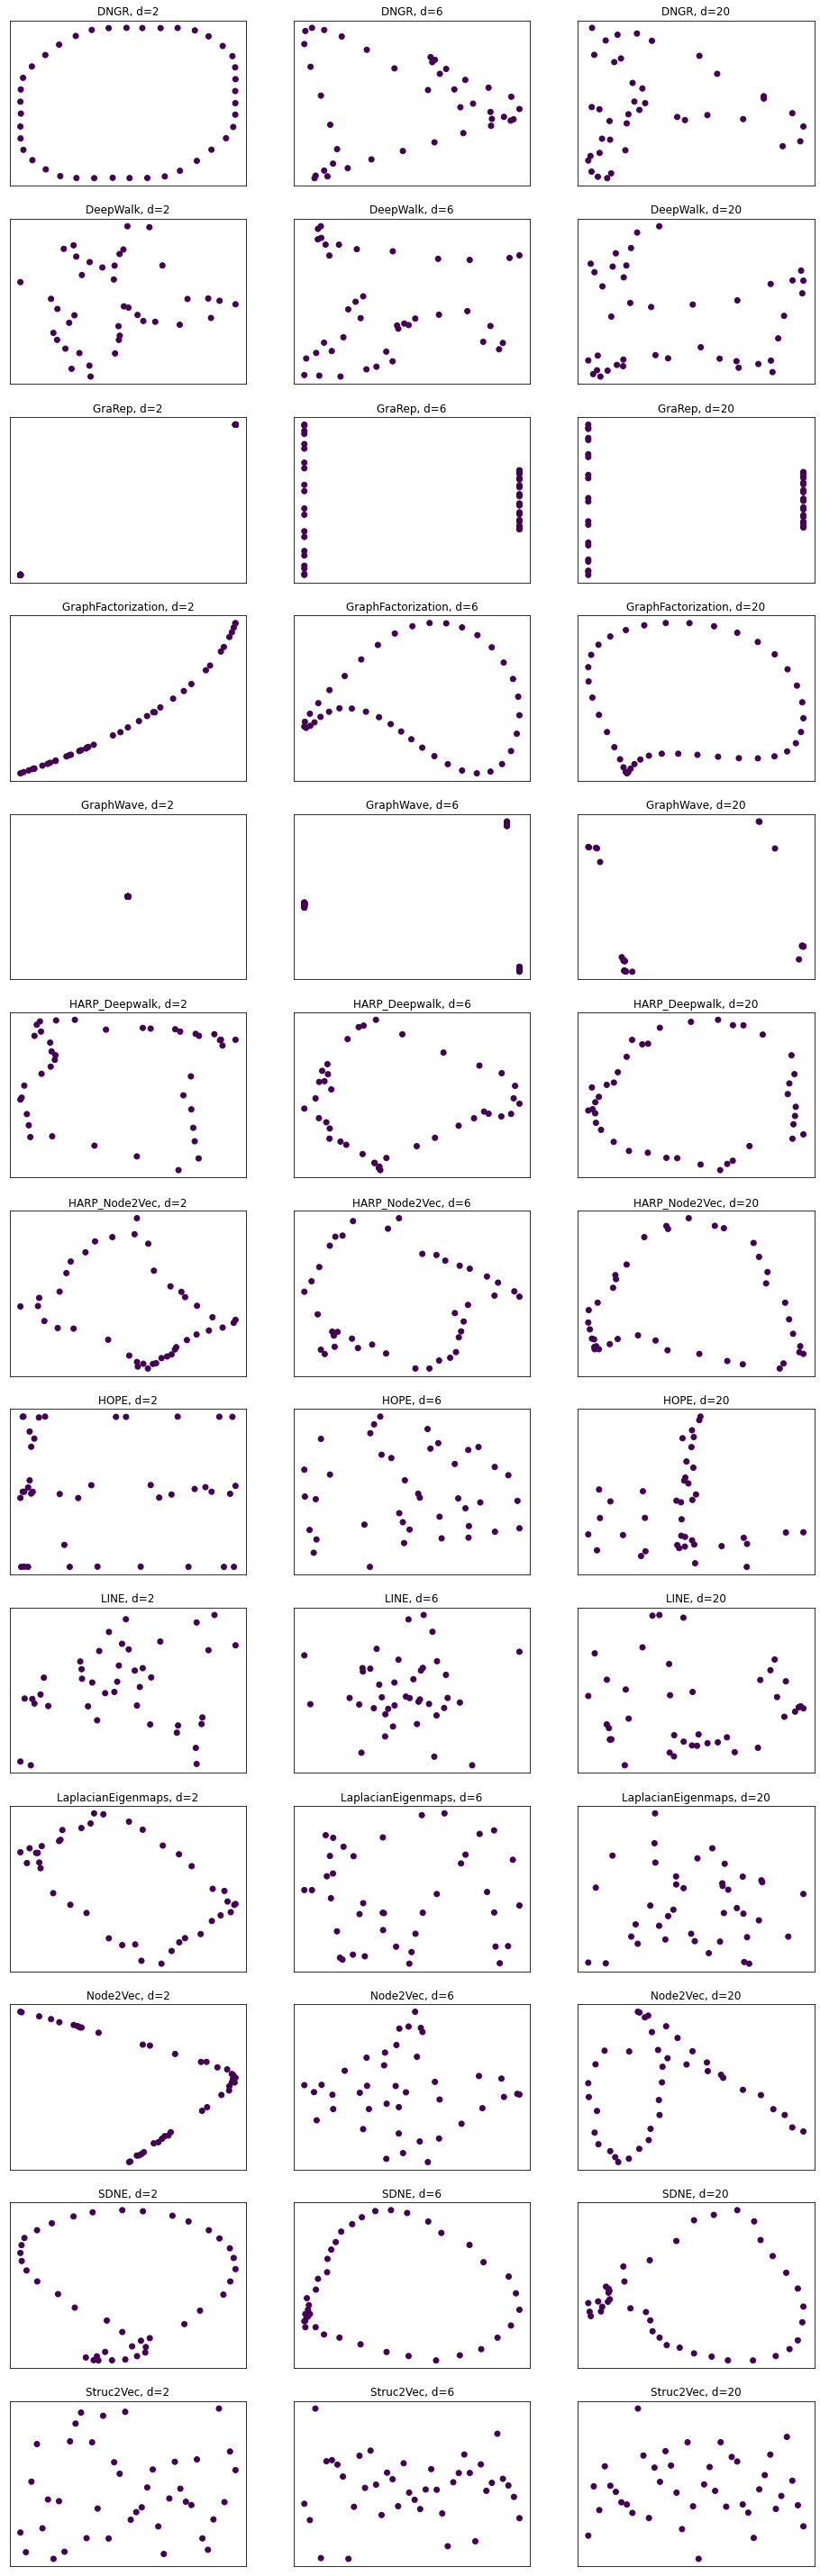

In [101]:
plot_embeddings_all_d(embeddings_d2[1], embeddings_d6[1], embeddings_d20[1], labels[1])
plt.savefig(f"Visualization/Visualization-G2.png", transparent=True)

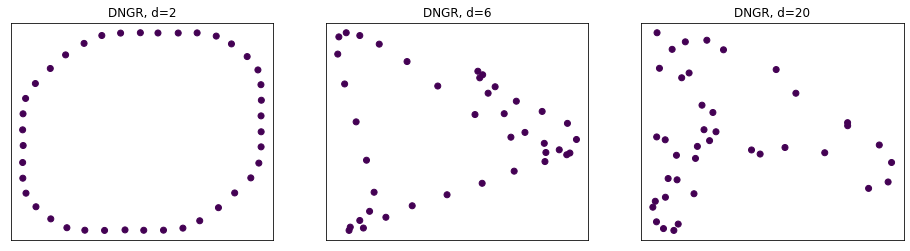

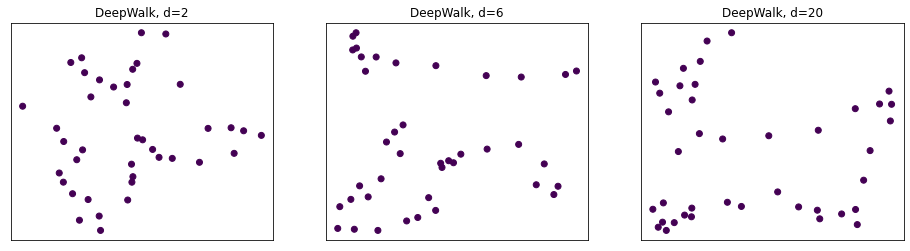

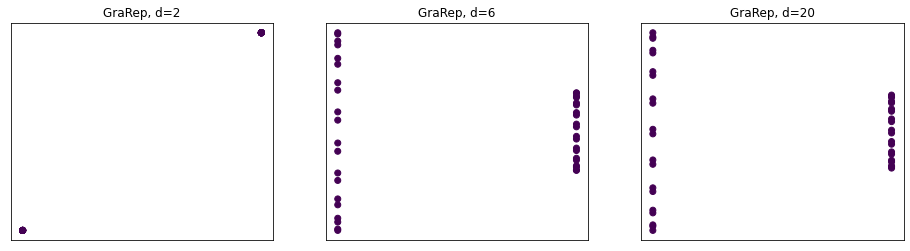

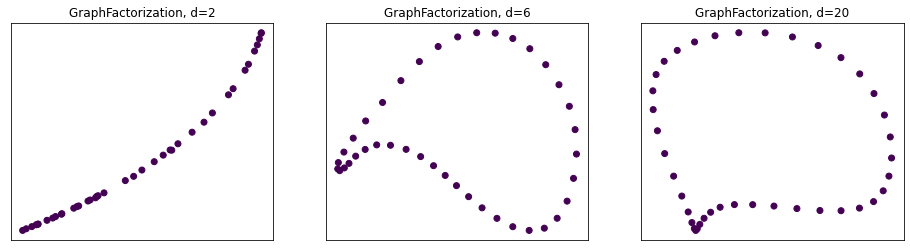

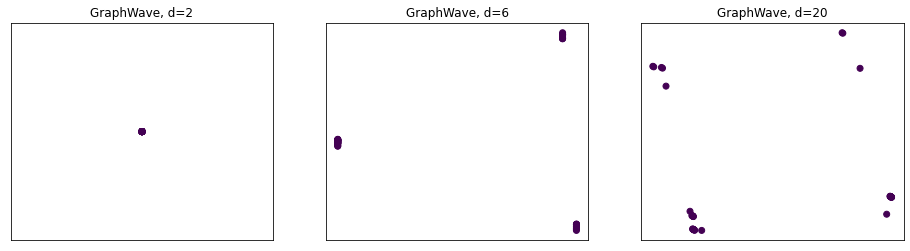

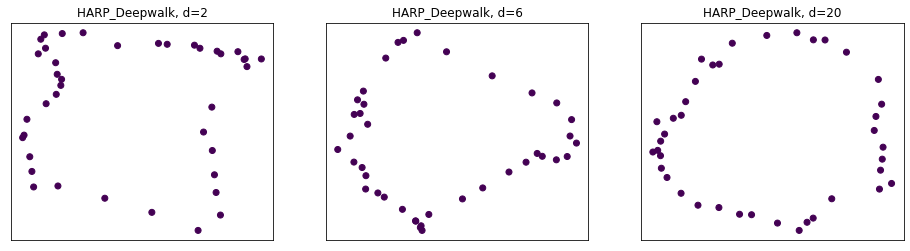

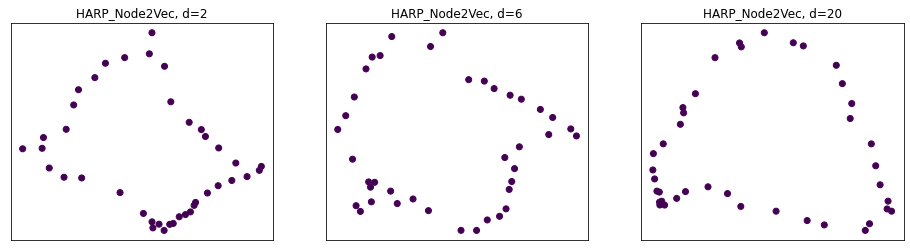

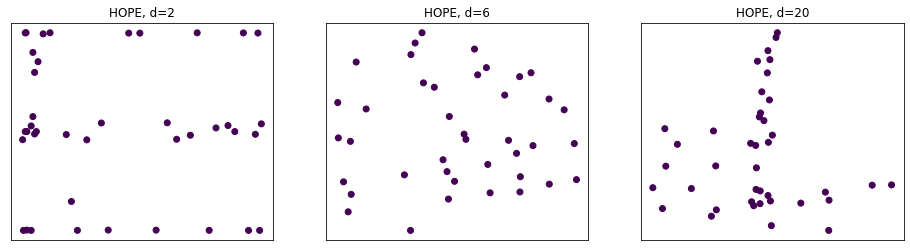

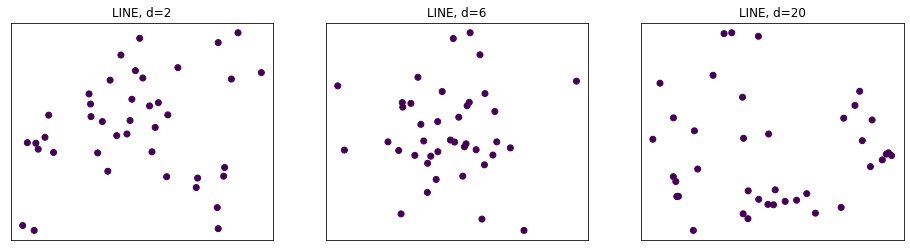

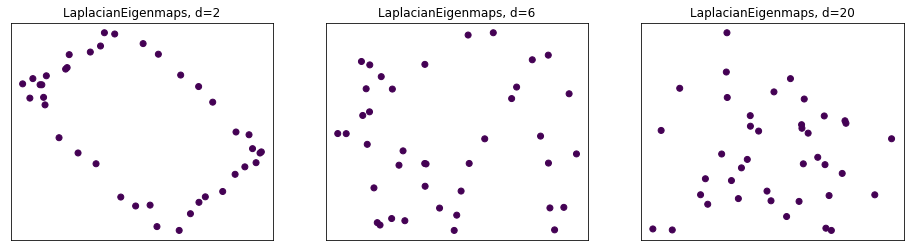

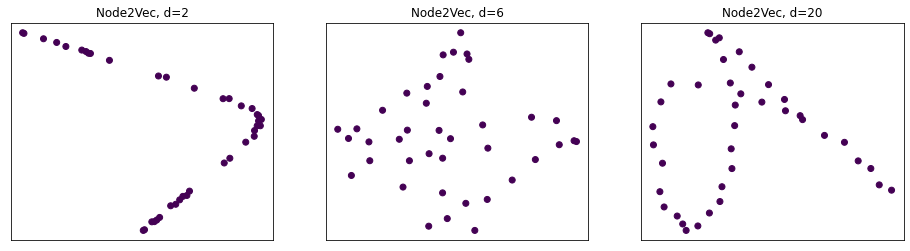

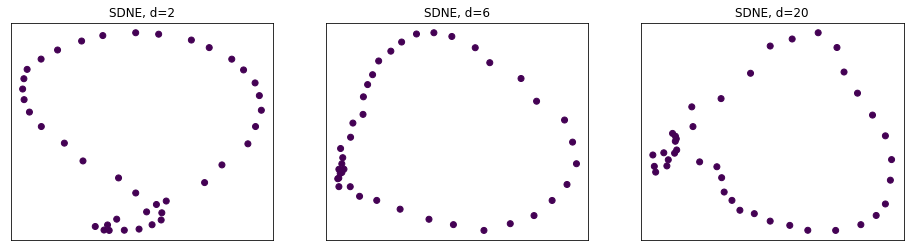

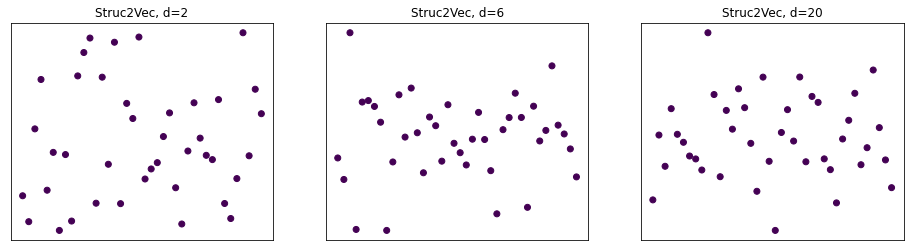

In [93]:
g_num = 1

for key in embeddings_d6[g_num].keys():
    ed2 = {key: embeddings_d2[g_num][key]}
    ed6 = {key: embeddings_d6[g_num][key]}
    ed20 = {key: embeddings_d20[g_num][key]}
    plot_embeddings_all_d(ed2, ed6, ed20, labels[g_num])
    plt.savefig(f"Visualization-G2-{key}.png", transparent=True)

### G3 - barely connected clusters

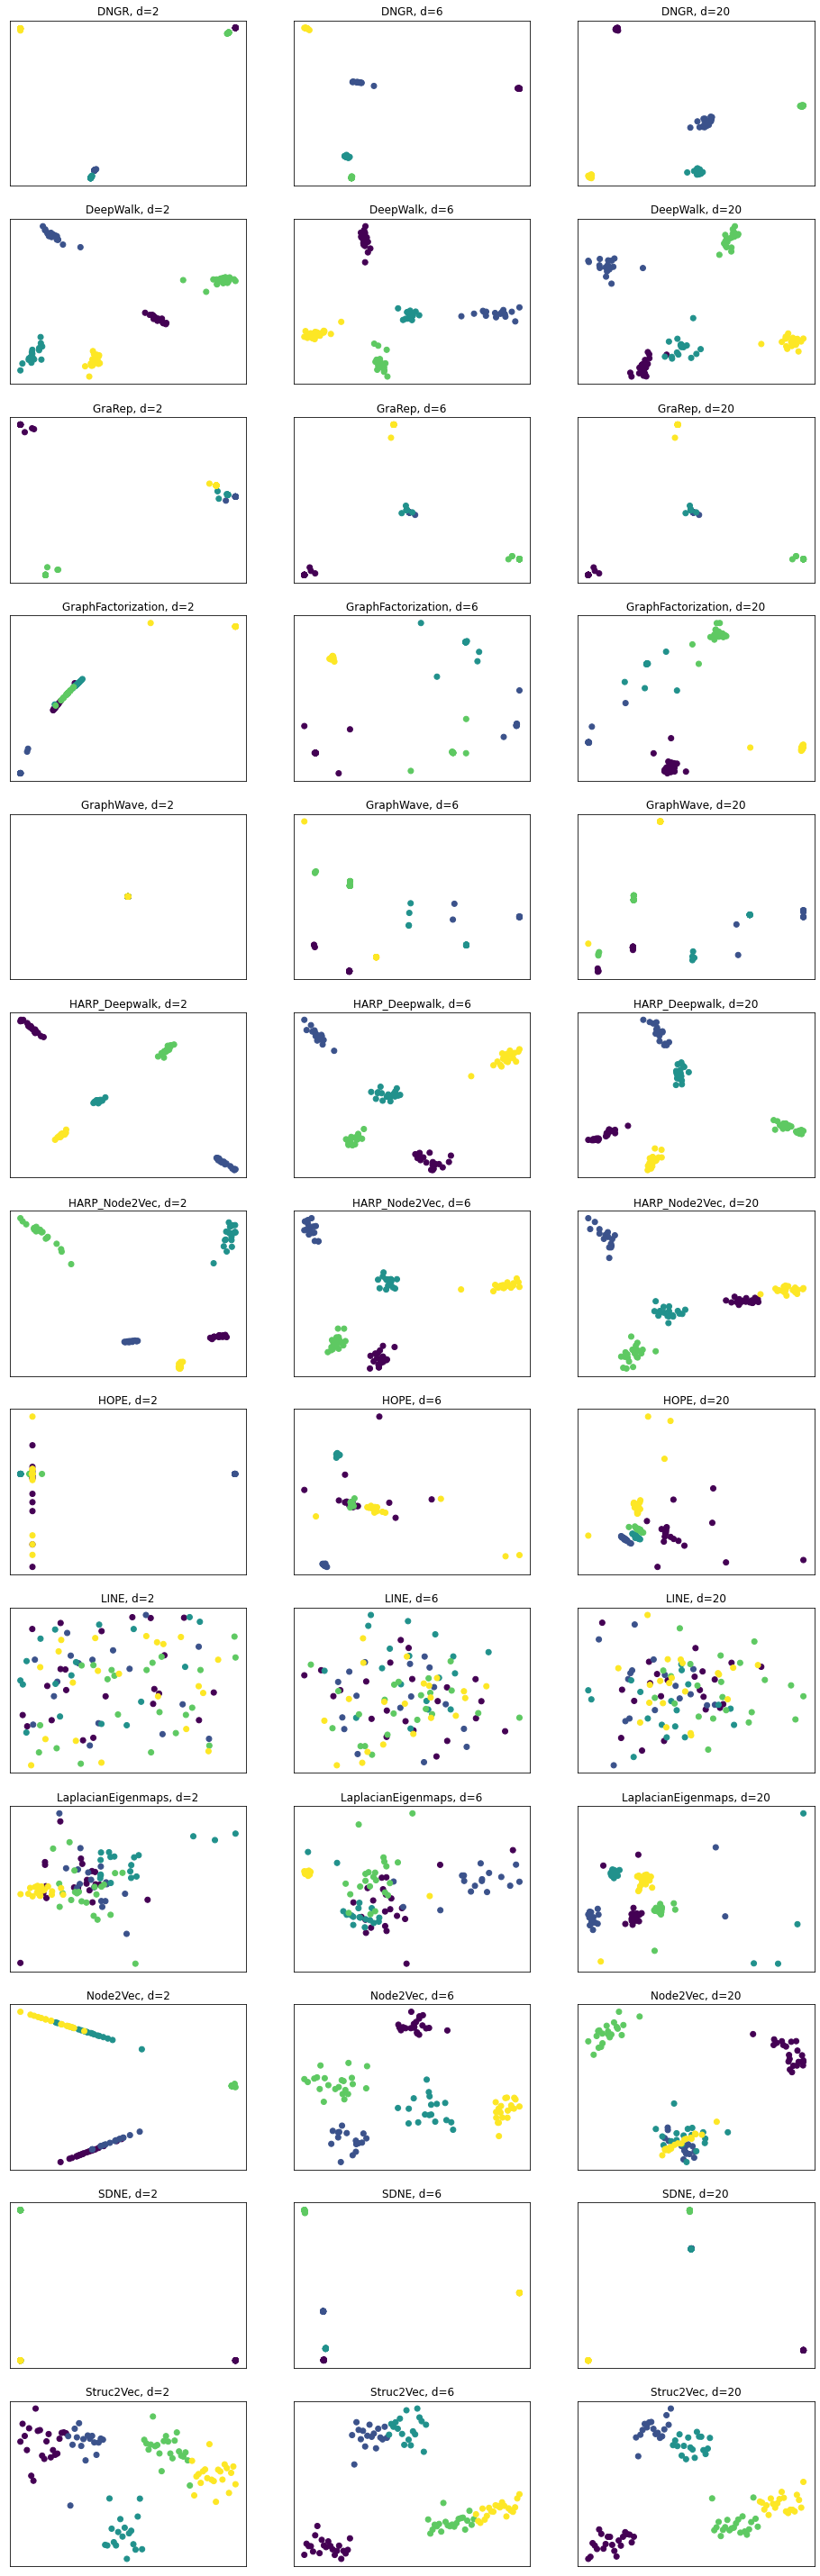

In [102]:
plot_embeddings_all_d(embeddings_d2[2], embeddings_d6[2], embeddings_d20[2], labels[2])
plt.savefig(f"Visualization/Visualization-G1.png", transparent=True)

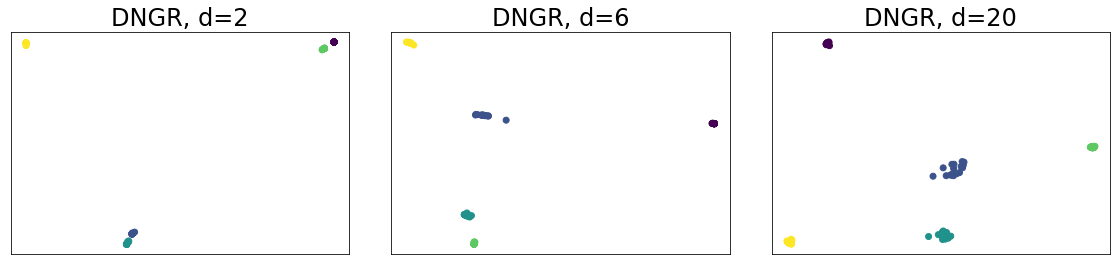

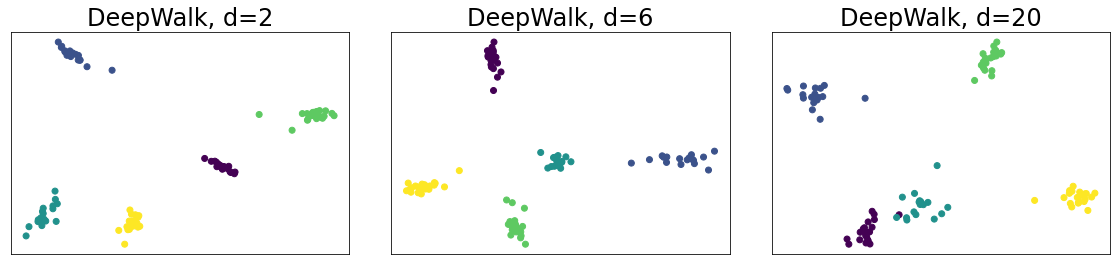

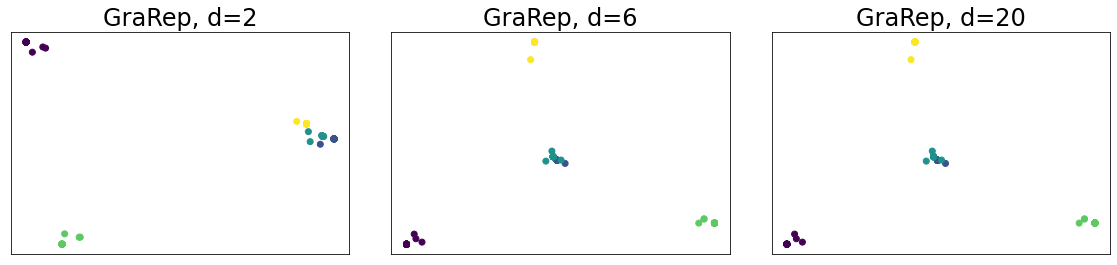

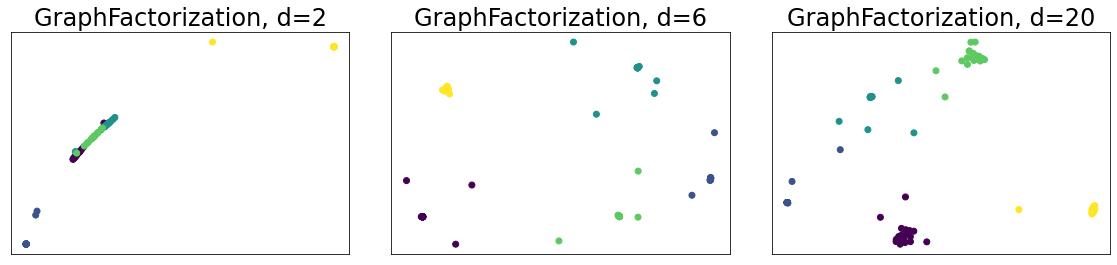

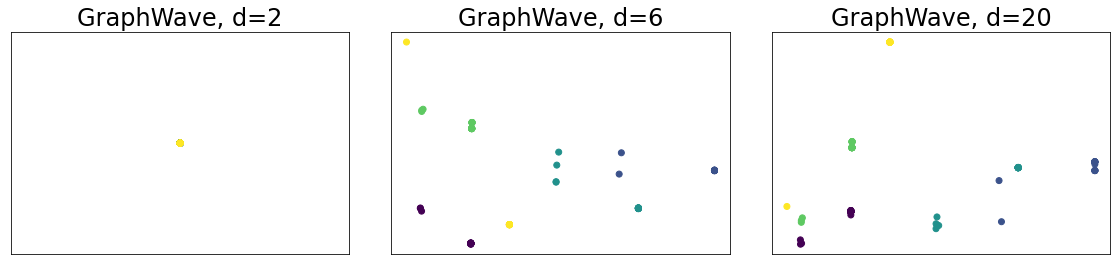

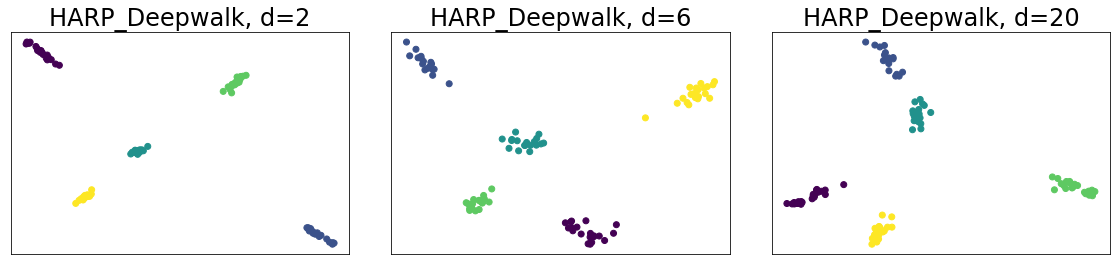

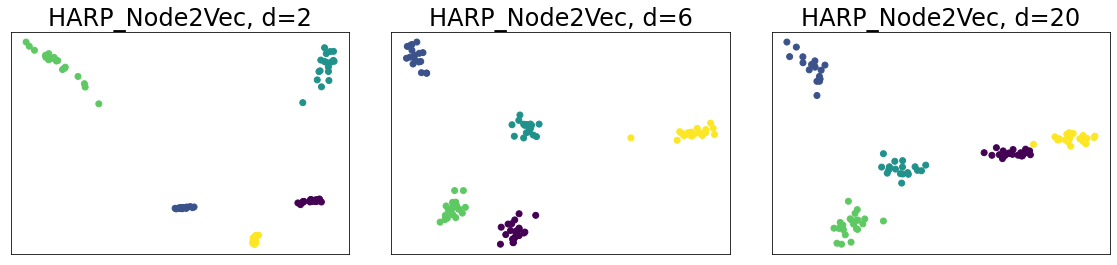

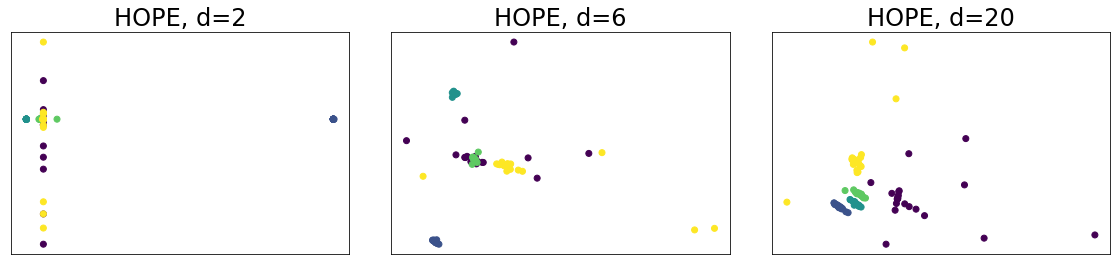

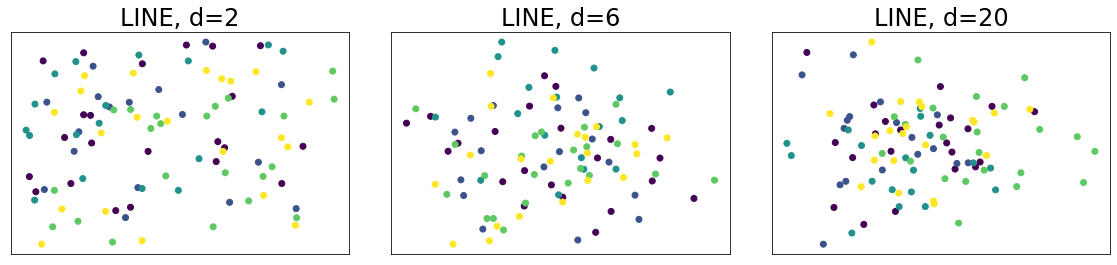

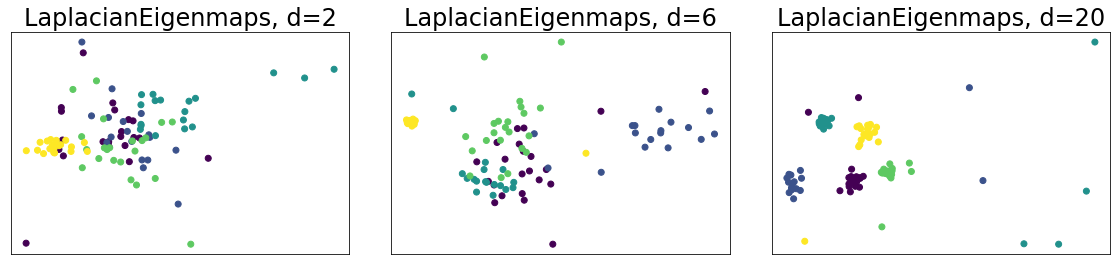

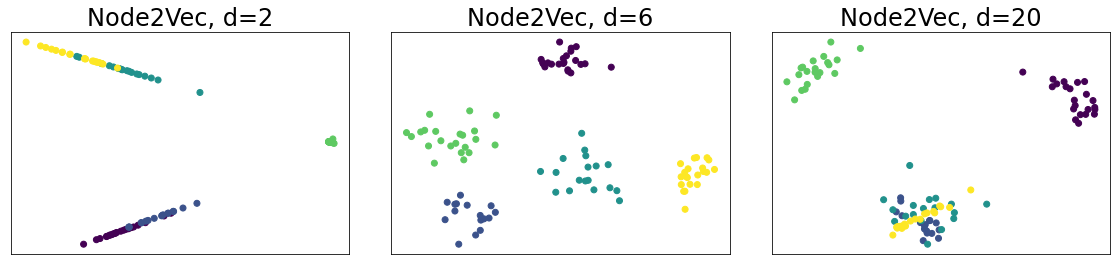

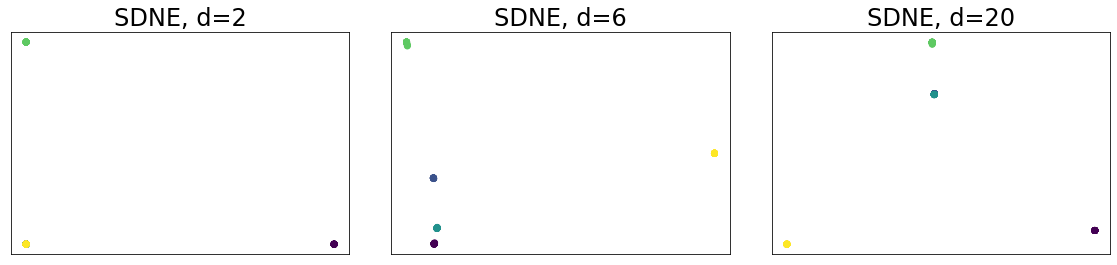

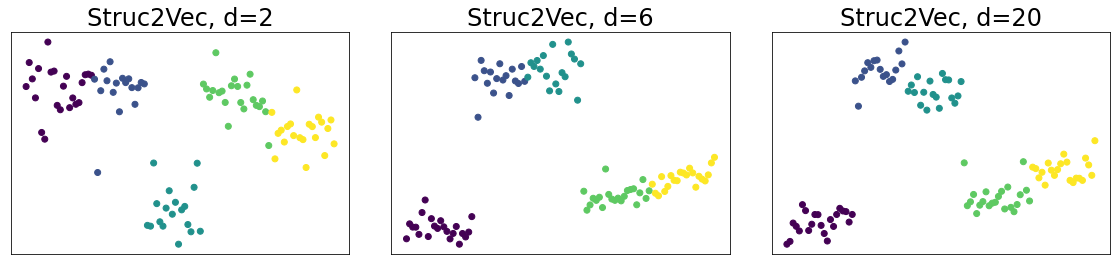

In [19]:
g_num = 2

for key in embeddings_d6[g_num].keys():
    ed2 = {key: embeddings_d2[g_num][key]}
    ed6 = {key: embeddings_d6[g_num][key]}
    ed20 = {key: embeddings_d20[g_num][key]}
    plot_embeddings_all_d(ed2, ed6, ed20, labels[g_num])
    plt.savefig(f"Visualization/Visualization-G3-{key}.png", transparent=True)

### G4 - loosely connected clusters

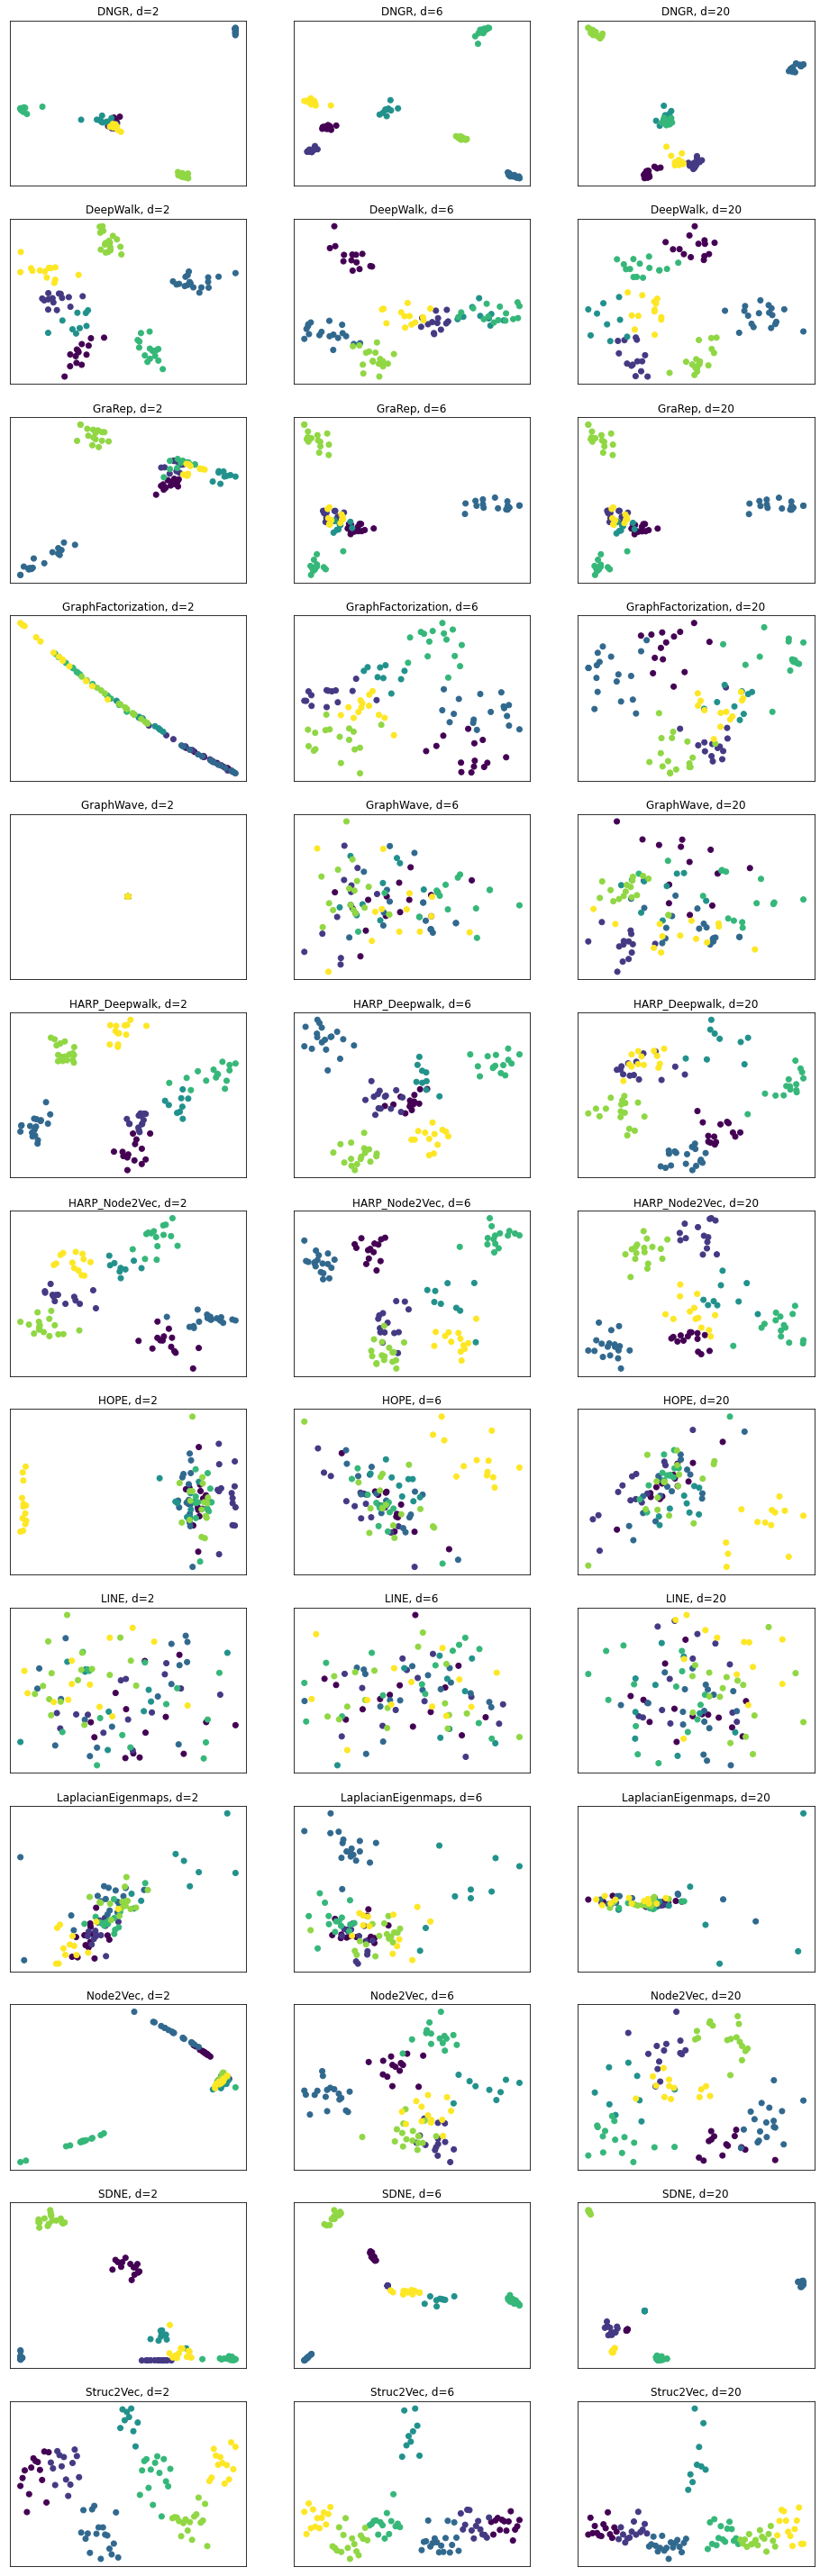

In [103]:
plot_embeddings_all_d(embeddings_d2[3], embeddings_d6[3], embeddings_d20[3], labels[3])
plt.savefig(f"Visualization/Visualization-G4.png", transparent=True)

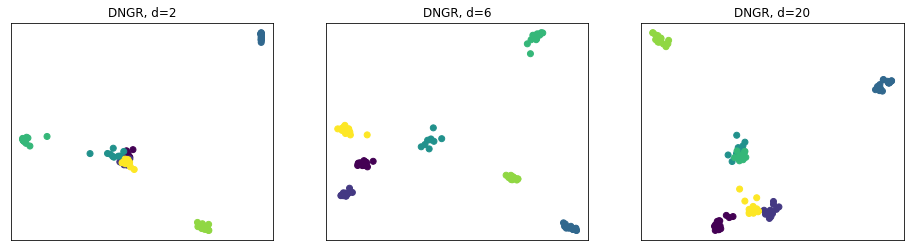

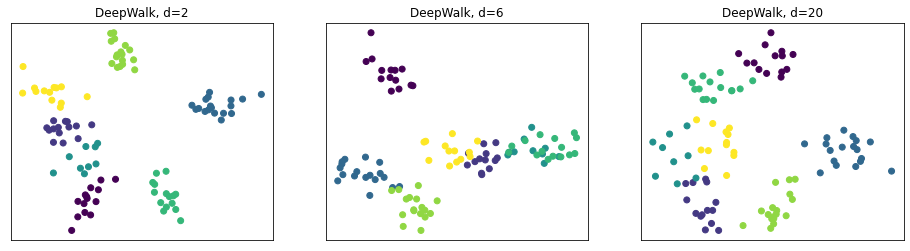

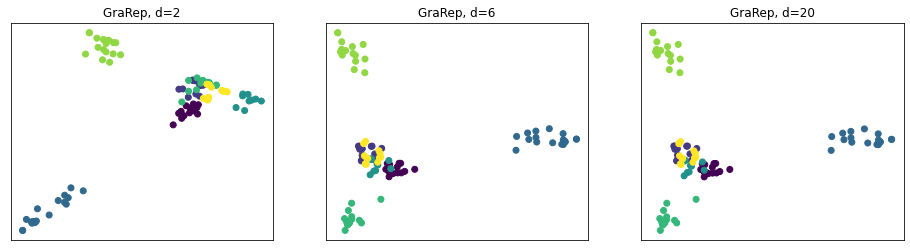

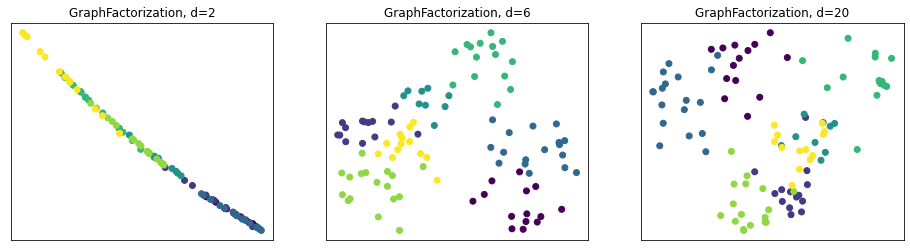

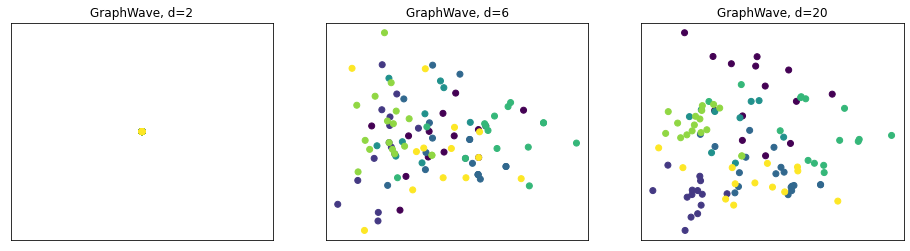

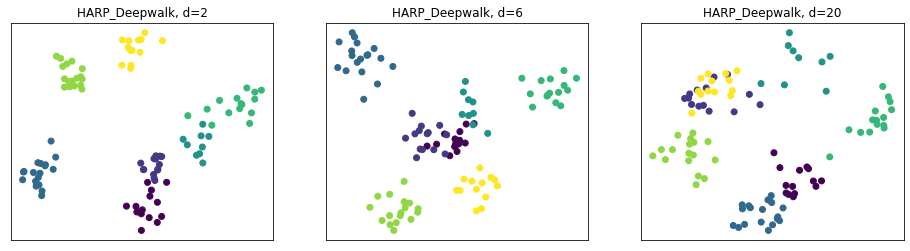

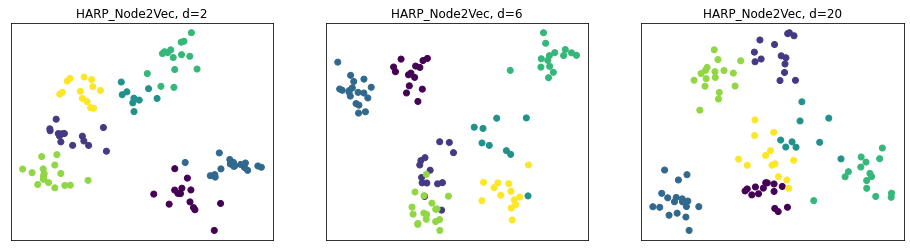

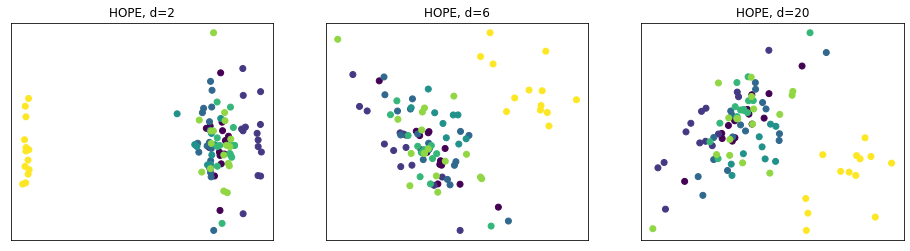

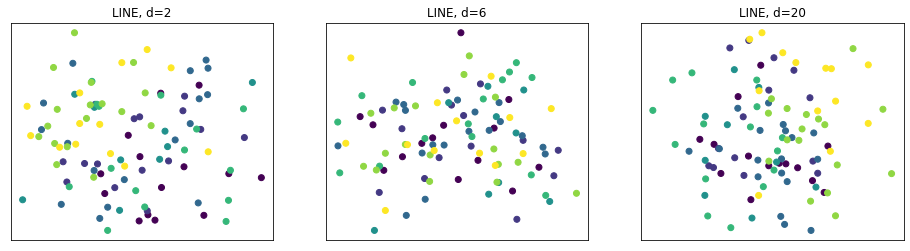

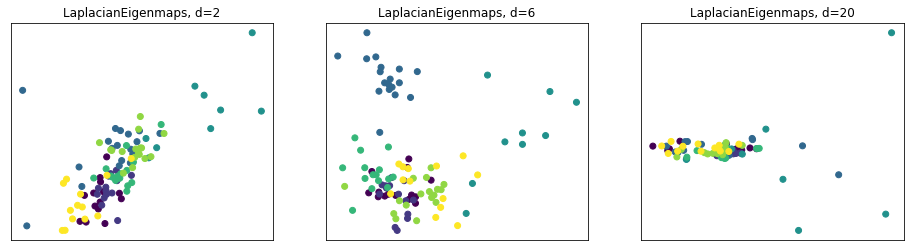

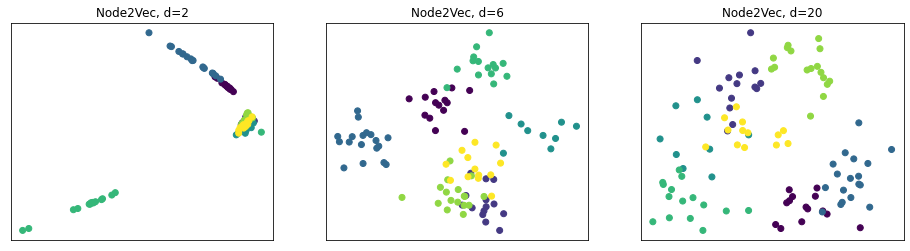

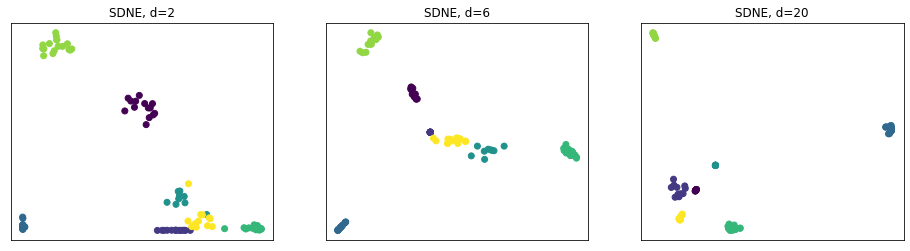

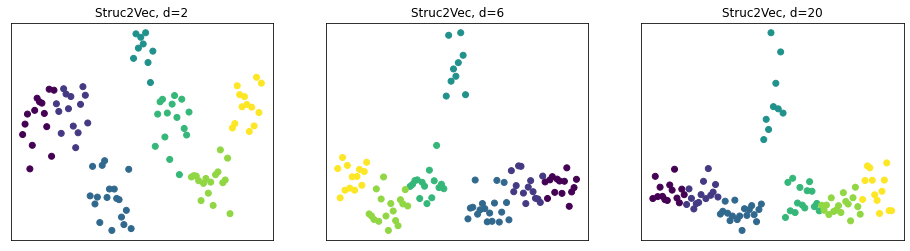

In [97]:
g_num = 3

for key in embeddings_d6[g_num].keys():
    ed2 = {key: embeddings_d2[g_num][key]}
    ed6 = {key: embeddings_d6[g_num][key]}
    ed20 = {key: embeddings_d20[g_num][key]}
    plot_embeddings_all_d(ed2, ed6, ed20, labels[g_num])
    plt.savefig(f"Visualization-G4-{key}.png", transparent=True)

### G5 - weak connections inside clusters

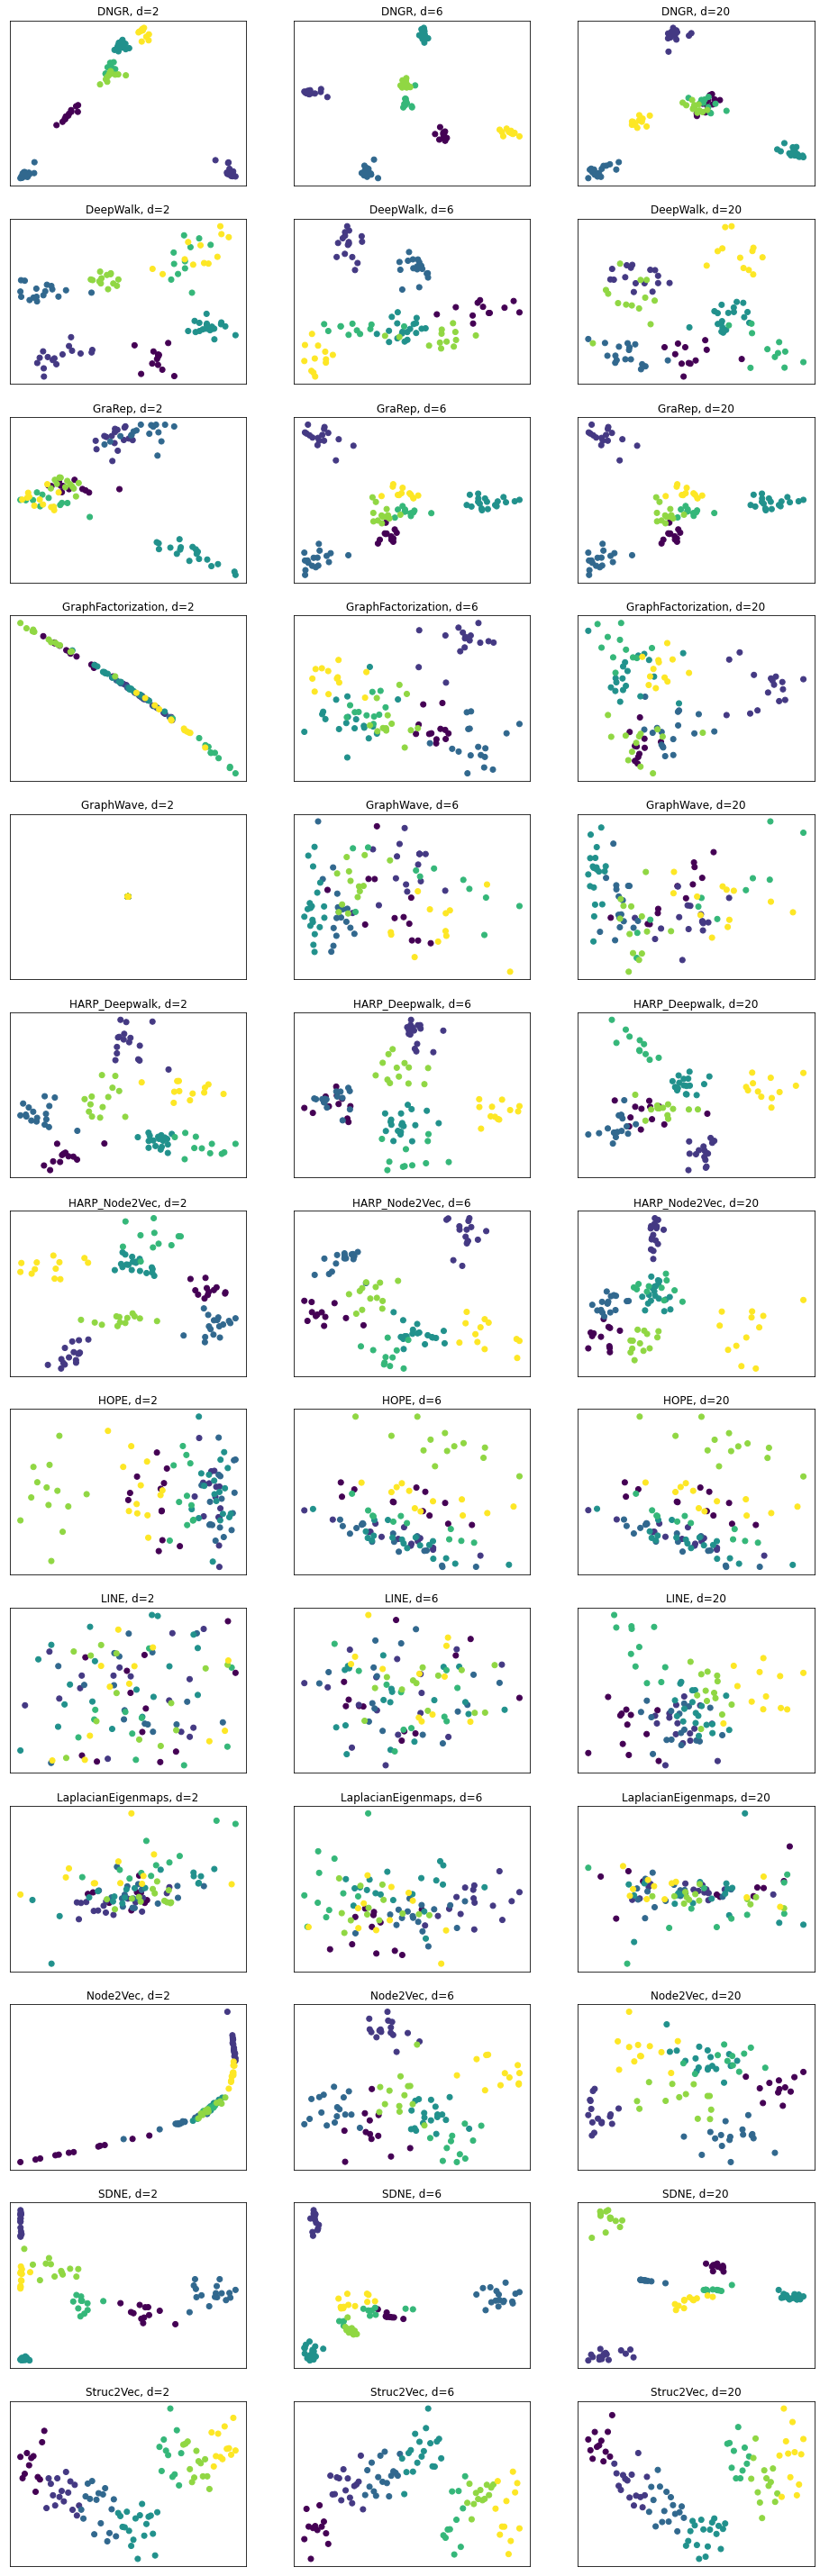

In [104]:
plot_embeddings_all_d(embeddings_d2[4], embeddings_d6[4], embeddings_d20[4], labels[4])
plt.savefig(f"Visualization/Visualization-G5.png", transparent=True)

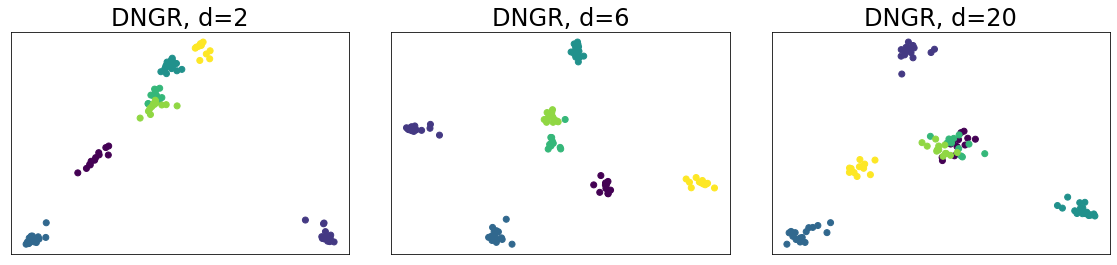

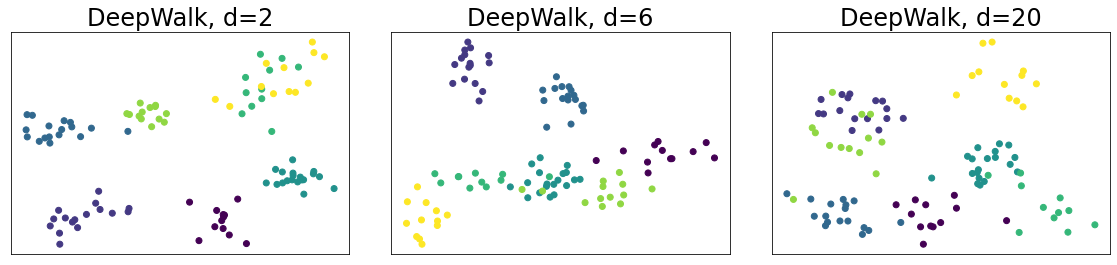

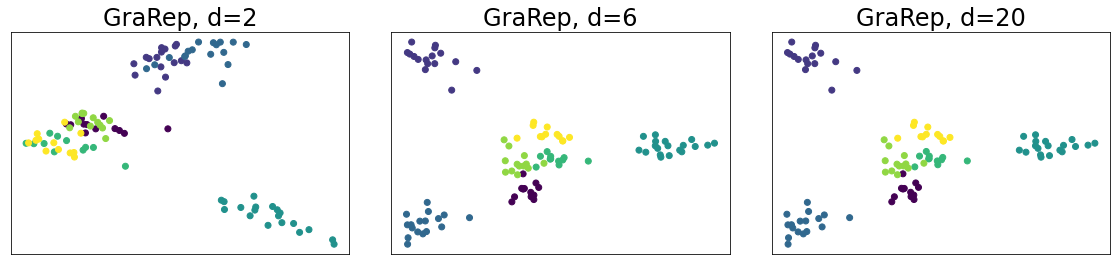

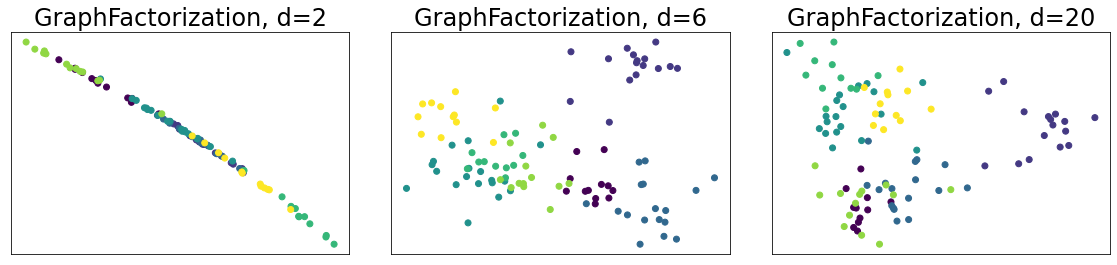

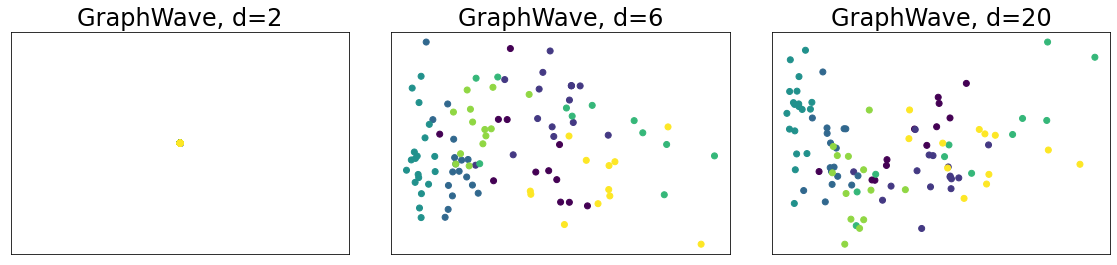

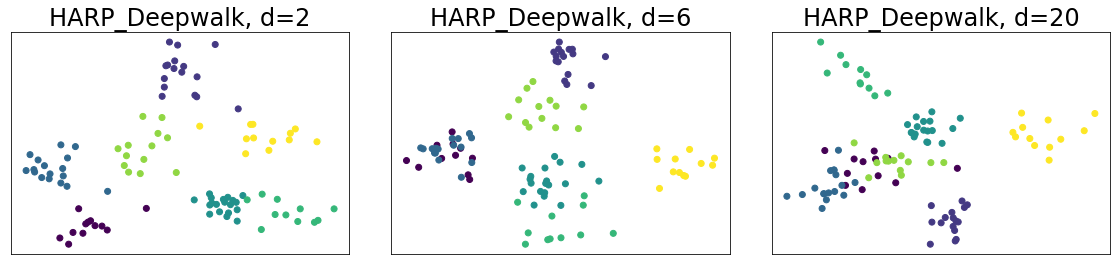

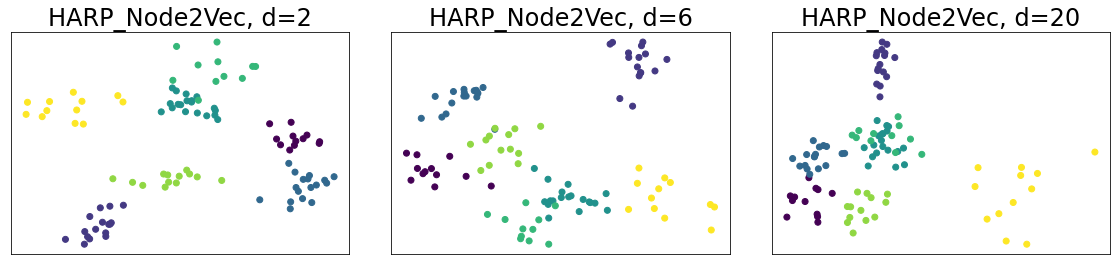

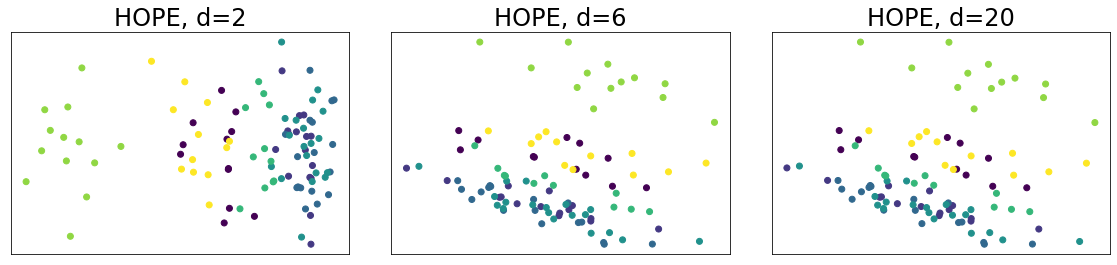

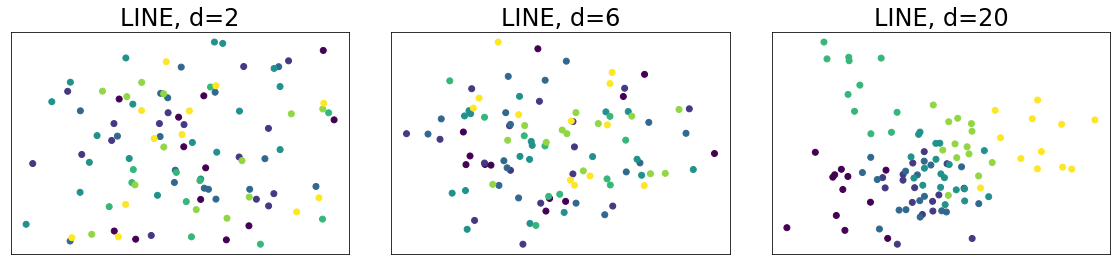

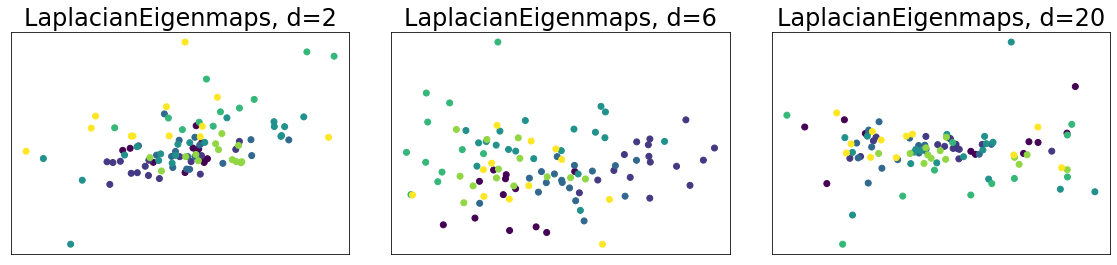

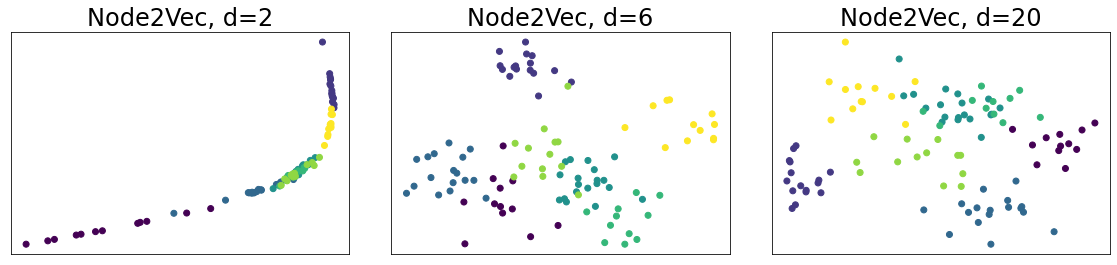

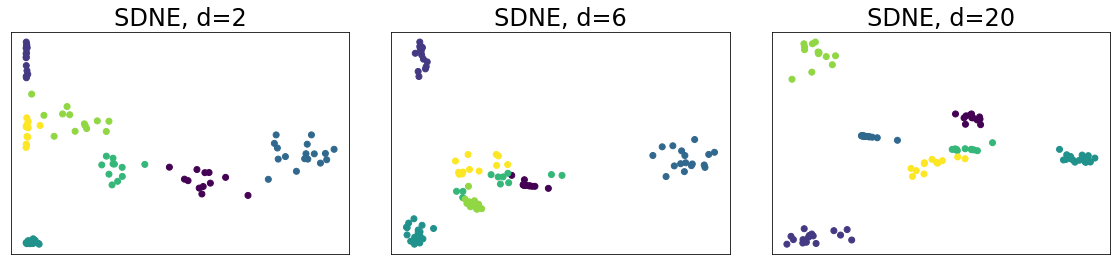

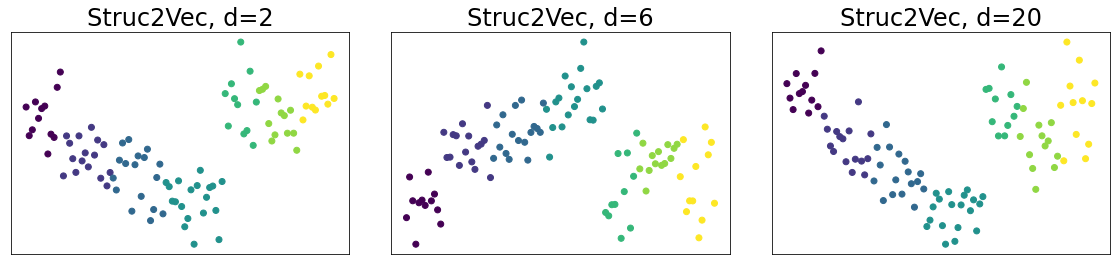

In [20]:
g_num = 4

for key in embeddings_d6[g_num].keys():
    ed2 = {key: embeddings_d2[g_num][key]}
    ed6 = {key: embeddings_d6[g_num][key]}
    ed20 = {key: embeddings_d20[g_num][key]}
    plot_embeddings_all_d(ed2, ed6, ed20, labels[g_num])
    plt.savefig(f"Visualization/Visualization-G5-{key}.png", transparent=True)